## Load Data

In [10]:
from sqlalchemy import create_engine
from datetime import datetime
import pandas as pd
import os

today = datetime.now().strftime("%Y-%m-%d")

try:
    MJ_ETL_DB = os.environ.get('MJ_ETL_DB')
    engine = create_engine(MJ_ETL_DB)
    # query
    metrics_df = pd.read_sql(f"SELECT * FROM metrics WHERE date_id = '{today}'", con=engine)
    events_df = pd.read_sql(f"SELECT * FROM events WHERE date_id = '{today}'", con=engine)
    # store csv
    metrics_df.to_csv('metrics.csv', index=False)
    events_df.to_csv('events.csv', index=False)
    print(metrics_df.shape, events_df.shape)
except BaseException as e:
    print(e)

(1152, 5) (2577, 7)


## Analytics

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json

metrics_df = pd.read_csv("metrics.csv")
metrics_df['timestamp_id'] = pd.to_datetime(metrics_df['timestamp_id'])
metrics_df.head()

,date_id,timestamp_id,name,date,value
0,2023-05-12,2023-05-12 00:00:44,jobs.time_to_start.fast.10min.job_type_kdpt_di...,2023-05-11 23:59:58,0.0086
1,2023-05-12,2023-05-12 00:00:44,jobs.time_to_start.fast.10min.job_type_v4_anim...,2023-05-11 23:59:58,0.0048
2,2023-05-12,2023-05-12 00:00:44,jobs.time_to_start.fast.10min.job_type_v4_diff...,2023-05-11 23:59:58,0.0347
3,2023-05-12,2023-05-12 00:00:44,jobs.time_to_start.fast.10min.job_type_v4_upsc...,2023-05-11 23:59:58,0.0138
4,2023-05-12,2023-05-12 00:00:44,jobs.time_to_start.fast.10min.job_type_v5_diff...,2023-05-11 23:59:58,0.0095


In [2]:
metrics_df['time'] = metrics_df['timestamp_id'].dt.strftime('%H:%M')
metrics_df['kind'] = metrics_df['name'].str.split('.').map(lambda x: x[2])
metrics_df['label'] = metrics_df['name'].str.split('.').map(lambda x: ''.join(x[4:]).replace('job_type_', ''))
data_df = metrics_df[['label',  'kind', 'time', 'value']]
data_df

,label,kind,time,value
0,kdpt_diffusion_anime,fast,00:00,0.0086
1,v4_anime_upscaler,fast,00:00,0.0048
2,v4_diffusion,fast,00:00,0.0347
3,v4_upscaler,fast,00:00,0.0138
4,v5_diffusion,fast,00:00,0.0095
...,...,...,...,...
1147,v4_anime_upscaler,relax,23:45,0.1137
1148,v4_diffusion,relax,23:45,3.8066
1149,v4_upscaler,relax,23:45,3.5486
1150,v5_diffusion,relax,23:45,2.1205


/var/folders/wm/9wwlc6rd38zd1kc_bjf3tl2c0000gn/T/ipykernel_63862/4225288566.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


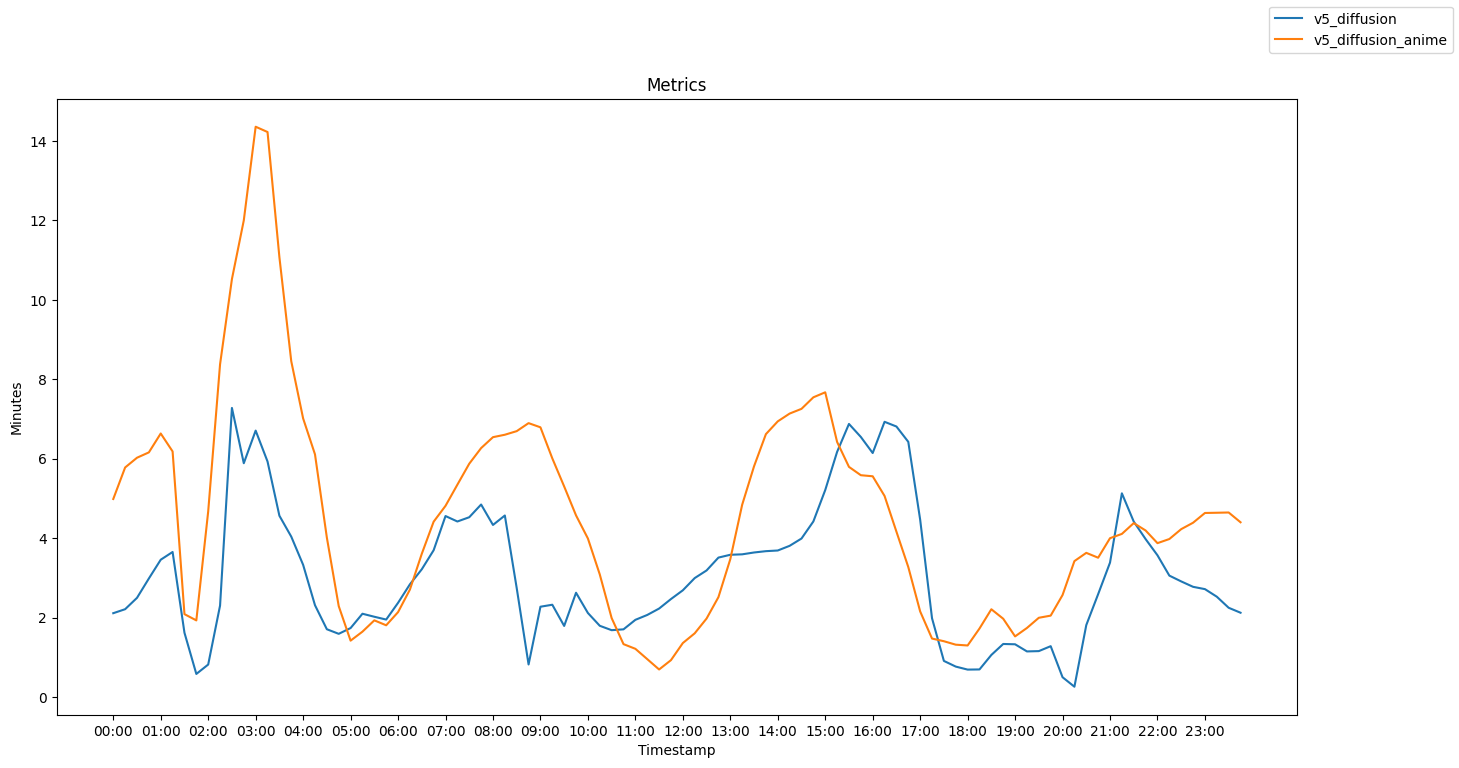

In [3]:
labels = data_df['label'].unique()
labels = labels[4:]

fig, ax = plt.subplots(figsize=(16, 8))
ax.set_title(f'Metrics')

KIND = 'relax'
plot_df = data_df[(data_df['kind'] == KIND)]
for label in labels:
    df = plot_df.loc[data_df['label'] == label]
    with open(f'./metrics/{KIND}/{label}.json', 'w') as f:
        json.dump(list(df['value'].values), fp=f)
    x = df['time']
    y = df['value']
    ax.set_label(label)
    ax.plot(x, y)

ax.set_xlabel('Timestamp')
ax.set_xticks([x.iloc[i] for i in range(0, len(x), 4)])
ax.set_ylabel('Minutes')
fig.legend(labels)
fig.show()

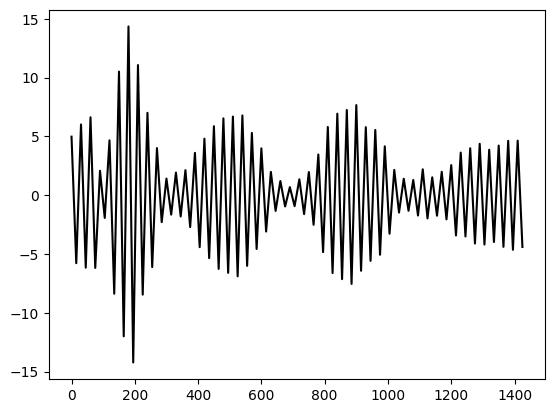

In [185]:
import numpy as np
from scipy.fft import fft, ifft

# x = df['time'].values
minutes = pd.to_datetime(df['time'], format="%H:%M").map(lambda x: x.hour * 60 + x.minute)
x = minutes.values
y = df['value'].values

fft_y = fft(y)
freqs = np.fft.fftfreq(len(y), x[1]-x[0])
idx = np.argsort(freqs)
freqs = freqs[idx]
fft_y = fft_y[idx]

y_fit = np.real(ifft(fft_y))
# plt.plot(x, y, 'b.', label='Original Data')
plt.plot(x, y_fit, label='Fitted Curve', color='k')
# plt.legend()
# plt.axis('off')
plt.show()

/var/folders/wm/9wwlc6rd38zd1kc_bjf3tl2c0000gn/T/ipykernel_34969/2220269196.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


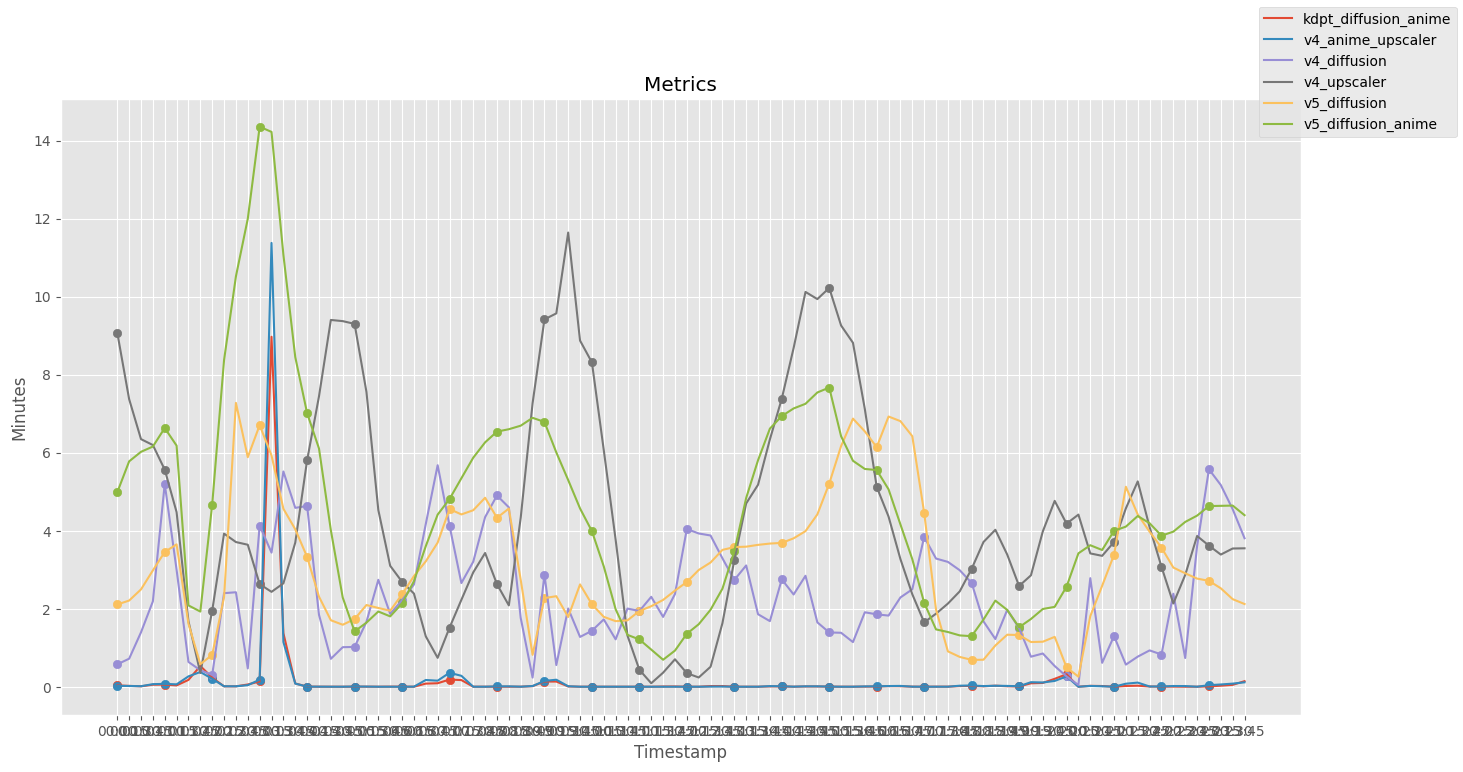

In [11]:
plt.style.use('ggplot')

def fmt(x: str):
    return x.replace('jobs.time_to_start.relax.30min.job_type_', '')

# plot
def plot(df: pd.DataFrame):
    # get unique names
    names = df['name'].unique()
    # plot
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title(f'Metrics')
    selected = names[-6:]    
    # lines
    for name in selected:
        data = df[df['name'] == name]
        x = data['timestamp_id'].dt.strftime("%H:%M")
        y = data['value']
        ax.set_label(fmt(name))
        ax.plot(x, y)
    # scatter
    for name in selected:
        data = df[df['name'] == name]
        hours = data.groupby([data['timestamp_id'].dt.hour])['value'].agg(lambda x: x.iloc[0]).reset_index()
        xs = pd.to_datetime(hours['timestamp_id'], format="%H").dt.strftime("%H:%M")
        ys = hours['value']
        ax.scatter(xs, ys)
    
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Minutes')
    fig.legend([fmt(s) for s in selected])
    fig.show()

plot(today_df)

/var/folders/wm/9wwlc6rd38zd1kc_bjf3tl2c0000gn/T/ipykernel_34969/3375159381.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


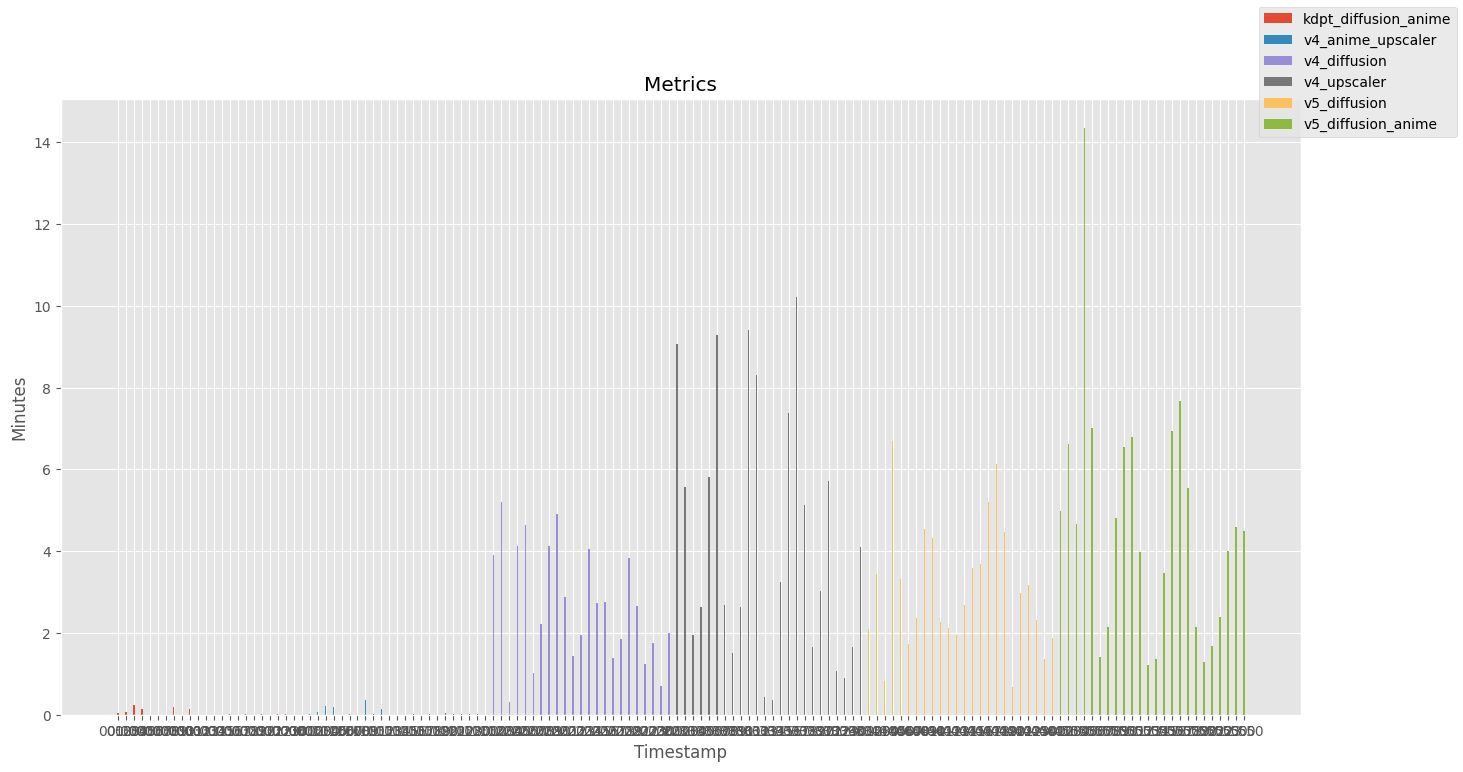

In [12]:
def fmt(x: str):
    return x.replace('jobs.time_to_start.relax.30min.job_type_', '')

# plot
def plot(df: pd.DataFrame):
    # get unique names
    names = df['name'].unique()
    # plot
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title(f'Metrics')
    selected = names[-6:]    
    # scatter
    for i, name in enumerate(selected):
        data = df[df['name'] == name]
        hours = data.groupby([data['timestamp_id'].dt.hour])['value'].agg(lambda x: x.iloc[0]).reset_index()
        xs = pd.to_datetime(hours['timestamp_id'], format="%H").dt.strftime("%H:%M")
        ys = hours['value']
        xs = xs.str.replace('00', f"{i * 60//6}".zfill(2))
        ax.bar(xs, ys, width=1/len(selected))
    
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Minutes')
    fig.legend([fmt(s) for s in selected])
    fig.show()

plot(metrics_df)